In [53]:
using Plots
using PyCall
using Images
using Statistics
rasterio = pyimport("rasterio");
scipy_interp = pyimport("scipy.interpolate");
include("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/structs/SlcRaw.jl");
include("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/load_s1slc_ann.jl");
include("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/salih2llh.jl");
include("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/llh2sali.jl");
include("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/load_pod.jl");
include("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/load_dem_subset.jl");
include("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/grid_dem.jl");
include("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/dem_interp.jl");

In [54]:
include("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/reproject_dem.jl")
# read dem path
f = open("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/dem_path.txt")
input_dem_path = readlines(f)[1]

# put output dem in same folder as input:
tmp = split(input_dem_path, ".")
output_dem_path = tmp[1] * "_reprojected." * tmp[2]

# choose projection from/to in epsg
from_projection = "4326+5773"
to_projection = "4979"

#Skal kun køres én gang
#reproject_dem(input_dem_path, output_dem_path, from_projection="4326+5773", to_projection="4979")

Processing /Users/eyu/YOEO_local/data/srtm_38_01/srtm_38_01.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image /Users/eyu/YOEO_local/data/srtm_38_01/srtm_38_01.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


Process(`gdalwarp /Users/eyu/YOEO_local/data/srtm_38_01/srtm_38_01.tif /Users/eyu/YOEO_local/data/srtm_38_01/srtm_38_01_reprojected.tif -s_srs EPSG:4326+5773 -t_srs EPSG:4979`, ProcessExited(0))

In [55]:
f = open("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/data_path.txt")
data_path = readlines(f)[1]

file = open("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/ann_path.txt")
ann_path = readlines(file)[1]
sar_parameters = load_s1slc_ann(ann_path)

file = open("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/POD_path.txt")
path = readlines(file)
osv, t_sv = load_pod(path[1], sar_parameters["t_0"]);

file = open("/Users/eyu/Google Drive/DTU/9_semester/synthesis/code/syntese/coords2index/dem_path_reproj.txt")
dem_path = readlines(file)[1];
dem_annotations = rasterio.open(dem_path);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [56]:
reflector_index = [[1126,6087],[1123, 6100],[1127, 6111]]

3-element Array{Array{Int64,1},1}:
 [1126, 6087]
 [1123, 6100]
 [1127, 6111]

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


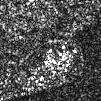

In [57]:
slc_view = [reflector_index[1][1]-50:reflector_index[1][1]+50, reflector_index[1][2]-50:reflector_index[1][2]+50]
slc_image = SlcRaw(slc_view, load_s1slc_ann(ann_path), load_s1slc_data(data_path, slc_view));
show_img(slc_image)

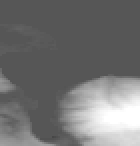

In [127]:
footprint_corners_lat, footprint_corners_lon = footprint(slc_image.meta, slc_view);
lat_corners_slc = [minimum(footprint_corners_lat), maximum(footprint_corners_lat)]
lon_corners_slc = [minimum(footprint_corners_lon), maximum(footprint_corners_lon)]

dem_cropped, dem_view = load_dem_subset(dem_annotations, lat_corners_slc, lon_corners_slc;
                              approx_ellipsoid_value=false, 
                              nan_fill=39,
                              lat_padding=30, lon_padding=30);
show_img(dem_cropped)

In [128]:
dem_lat_lon = grid_dem(dem_cropped, dem_annotations, dem_view);
llh = hcat(dem_lat_lon, reshape(dem_cropped, :));
dem_sample_line = llh2sali(llh, osv, t_sv, sar_parameters);
z = reshape(dem_cropped, :);

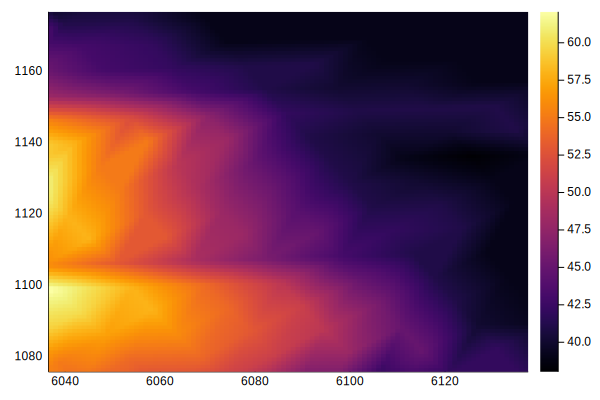

In [129]:
view = slc_view # slc_view[1] er rows dvs y og [2] er cols

# interpolate
z_grid = dem_interp(dem_sample_line[1:end,2], 
                    dem_sample_line[1:end,1], 
                    z[1:end], 
                    slc_view[2], 
                    slc_view[1]; x_step=1, y_step=1);

heatmap(slc_view[2],slc_view[1],z_grid)

In [130]:
lat_1 = slc_view[2] .== 6087;
lon_1 = slc_view[1] .== 1126;

lat_2 = slc_view[2] .== 6100;
lon_2 = slc_view[1] .== 1123;

lat_3 = slc_view[2] .== 6111;
lon_3 = slc_view[1] .== 1127;

In [131]:
#reflector_height = [42.753,43.282,44.475]
reflector_height = [z_grid[lat_1,lon_1], z_grid[lat_2,lon_2], z_grid[lat_3,lon_3]]

3-element Array{Array{Float64,2},1}:
 [44.2309]
 [43.3491]
 [41.5369]

In [132]:
padding = 2; # to display images

### Reflector in Image 1 15. Marts

In [4]:
path_img1 = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/measurement/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.tiff"
path_ann_1 = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE/annotation/s1b-iw3-slc-vv-20170315t053950-20170315t054018-004715-0083b0-006.xml"
path_pod_1 = "/Users/simon/Data/Sentinel/S1B_OPER_AUX_POEORB_OPOD_20170404T111500_V20170314T225942_20170316T005942.EOF"

"/Users/simon/Data/Sentinel/S1B_OPER_AUX_POEORB_OPOD_20170404T111500_V20170314T225942_20170316T005942.EOF"

In [5]:
reflector_index_img1 = [[1126,6087],[1123, 6100],[1127, 6111]]

3-element Array{Array{Int64,1},1}:
 [1126, 6087]
 [1123, 6100]
 [1127, 6111]

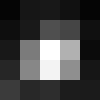

In [33]:
index = reflector_index_img1[1]
view =[(index[1]-padding):(index[1]+padding), (index[2]-padding):(index[2]+padding)]
show_img(load_s1slc_data(path_img1,view))

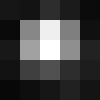

In [34]:
index = reflector_index_img1[2]
view =[(index[1]-padding):(index[1]+padding), (index[2]-padding):(index[2]+padding)]
show_img(load_s1slc_data(path_img1,view))

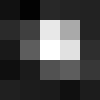

In [35]:
index = reflector_index_img1[3]
view =[(index[1]-padding):(index[1]+padding), (index[2]-padding):(index[2]+padding)]
show_img(load_s1slc_data(path_img1,view))

### Convert to coordinates

In [9]:
salih = hcat(vcat(reflector_index_img1'...),reflector_heigt)

3×3 Array{Float64,2}:
 1126.0  6087.0  42.753
 1123.0  6100.0  43.282
 1127.0  6111.0  44.475

In [12]:
meta_img1 = load_s1slc_ann(path_ann_1);
osv_1,t_sv_1 = load_pod(path_pod_1,meta_img1["t_0"]);

In [18]:
llh_1 = salih2llh(salih, osv_1, t_sv_1, meta_img1)

3×3 Array{Float64,2}:
 56.5619  8.30744  42.7529
 56.5623  8.30682  43.2819
 56.5619  8.30604  44.4749

## Find Indew in image 2  27. Marts

In [20]:
path_img2 = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE/measurement/s1b-iw3-slc-vv-20170327t053950-20170327t054018-004890-0088ae-006.tiff"
path_ann_2 = "/Users/simon/Data/Sentinel/S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE/annotation/s1b-iw3-slc-vv-20170327t053950-20170327t054018-004890-0088ae-006.xml"
path_pod_2 = "/Users/simon/Data/Sentinel/S1B_OPER_AUX_POEORB_OPOD_20170416T111343_V20170326T225942_20170328T005942.EOF"

"/Users/simon/Data/Sentinel/S1B_OPER_AUX_POEORB_OPOD_20170416T111343_V20170326T225942_20170328T005942.EOF"

In [21]:
meta_img2 = load_s1slc_ann(path_ann_2);
osv_2,t_sv_2 = load_pod(path_pod_2,meta_img2["t_0"]);

In [22]:
reflector_index_img2 = llh2sali(llh_1, osv_2, t_sv_2 ,meta_img2 )

3×2 Array{Float64,2}:
 1126.17  6070.31
 1123.17  6083.31
 1127.17  6094.31

In [28]:
round.(Int,reflector_index_img2)

3×2 Array{Int64,2}:
 1126  6070
 1123  6083
 1127  6094

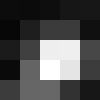

In [36]:
index = round.(Int,reflector_index_img2[1,:])
view =[(index[1]-padding):(index[1]+padding), (index[2]-padding):(index[2]+padding)]
show_img(load_s1slc_data(path_img2,view))

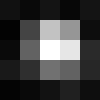

In [39]:
index = round.(Int,reflector_index_img2[2,:])
view =[(index[1]-padding):(index[1]+padding), (index[2]-padding):(index[2]+padding)]
show_img(load_s1slc_data(path_img2,view))

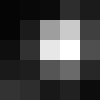

In [40]:
index = round.(Int,reflector_index_img2[3,:])
view =[(index[1]-padding):(index[1]+padding), (index[2]-padding):(index[2]+padding)]
show_img(load_s1slc_data(path_img2,view))

## Testing

In [111]:
lat_1 = (56 + 33/60 + 42.5556/(60*60))
lon_1 = (8 + 18/60 + 26.874/(60*60))
lat_2 = (56 + 33/60 + 44.4528/(60*60))
lon_2 = (8 + 18/60 + 24.865/(60*60))
lat_3 = (56 + 33/60 + 42.8652/(60*60))
lon_3 = (8 + 18/60 + 22.104/(60*60))
lat_lon = [[lat_1 lon_1]; [lat_2 lon_2]; [lat_3 lon_3]]

3×2 Array{Float64,2}:
 56.5618  8.30747
 56.5623  8.30691
 56.5619  8.30614

In [114]:
heights = [42.753, 43.282, 44.475]

3-element Array{Float64,1}:
 42.753
 43.282
 44.475

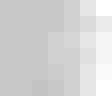

In [119]:
lat_corners_slc = [56.561820999999995 - 0.002, 56.562348 + 0.002]
lon_corners_slc = [8.306140000000001 - 0.002, 8.307465 + 0.002]

dem_cropped, dem_view = load_dem_subset(dem_annotations, lat_corners_slc, lon_corners_slc;
                              approx_ellipsoid_value=false, 
                              nan_fill=39,
                              lat_padding=0, lon_padding=0);
show_img(dem_cropped)

In [120]:
lat_range = LinRange(lat_corners_slc[1], lat_corners_slc[2], 6)
lon_range = LinRange(lon_corners_slc[1], lon_corners_slc[2], 7);

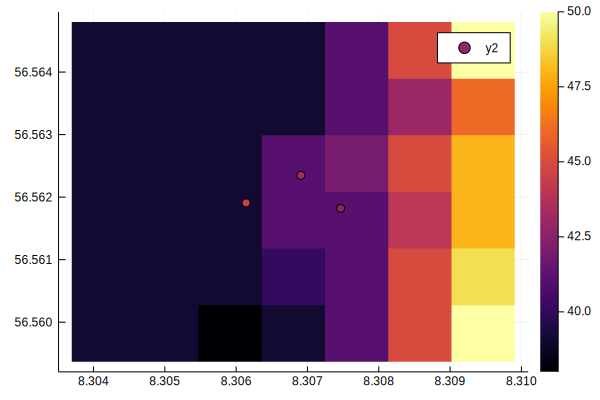

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not refelct all series correctly.
└ @ Plots /Users/eyu/.julia/packages/Plots/Ih71u/src/backends/gr.jl:483


In [121]:
heatmap(lon_range, lat_range, dem_cropped[end:-1:1, :])
scatter!(lat_lon[:, 2], lat_lon[:, 1], marker_z=heights)

In [122]:
dem_cropped

6×7 Array{Int16,2}:
 39  39  39  39  41  45  50
 39  39  39  39  41  43  46
 39  39  39  41  42  45  48
 39  39  39  41  41  44  48
 39  39  39  40  41  45  49
 39  39  38  39  41  45  50